
<img alt='UCL' src="images/ucl_logo.png" align='center'>



# Formative Assessment: LAI

*Although we provide access to answers for this exercise, we want you to submit the codes you generate via Moodle, so that we can provide feedback. You should avoid looking at the answers before you submit your work. This submitted work does not count towards your course assessment, it is purely to allow us to provide some rapid feedback to you on how you are doing. You will need to put together a few elements from the notes so far to do all prts of this practical, but yoiu should all be capable of doing it well. Pay attention to writing tidy code, with useful, clear comments and document strings.*



#### Exercise 1

Write a Python script to generate a combined LAI and land cover dataset, for a given year, tile set, and country

* In a file `work/lc_lai.py`, write a function called `lc_lai` that has has the following arguments:

        * tile     : list of MODIS tile names e.g `['h17v03','h18v03','h17v04','h18v04']`
        * year     : integer, e.g. `2018`
        * fips     : a FIPS country code string e.g. `LU`

  the following keyword options:
  
        * sigma=5  : std dev for Gaussian smoothing filter (default 5)

  and returns a dictionary with the following keys:

        'Lai_500m'   : regularised (interpolated) LAI: numpy float array of (Ndays,Nx,Ny) 
        'mask'       : a mask True for valid pixels: numpy bool array of (Nx,Ny)
        'LC_Type3'   : Land cover: numpy byte array of (Nx,Ny) 
        'doy'        : array of integers of the day of year the lai


* In the same file, write a function `write_dataset` that takes as argument:

         dataset     : the LAI, mask and LC dataset returned by  lc_lai
         ofile       : str or Path object for output file
         
   the following keyword options:
  
         classy='Deciduous Broadleaf Forests' : name for LC_Type3 LC class

    and saves the doy and  mean LAI over the specified country to a CSV text file in ofile.
    
    The function should also print out the number of samples for that land cover type (Hint: sum the combined valid/land cover mask), and not proceed further if there are no samples for the given LC class.

* In the same file, write a function  `main()` that runs a test of `lc_lai` and `get_dataset` for the following scenario:

        tile : `['h17v03','h18v03','h17v04','h18v04']`
        year : `2018`
        fips : 'BE' (Belgium)
    
  and them reads and prints the doy and mean LAI from the file you have saved.
  
* Run your script in a jupyter notebook, and and plot the dataset returned.

Hint, use existing codes as far as possible, and re-purpose to this task. For example, you may find it convenient to use `geog0111.modis_annual` to get teh MODIS dataset.

Rather than writing one huge function, you may find it useful to write a series of functions that you put together into the function `lc_lai`. For example, you might build a function to get the clipped LAI dataset, anothe to do the interpolation, another to get the land cover data, and another to build the mask. 

If you build the code as a series of smaller functions like this, test them as you go along. e.g. test that the function that getrs the LAI dataset works as intended before going on to the others. Check the data returned by looking at its shape, and perhaps doing some plots. You might find it useful to put all of thes tests into a notebook, so they become repeatable.

Try to put checks into your code to ensure it is operating as intended.

Hint: if you modularise your code in this way, the bare bones of the function will be as simple as something like:

        def lc_lai(tile,year,fips,sigma=5):
            lc               = get_lc(year,tile,fips)
            lai,std,doy      = get_lai(year,tile,fips)
            weight           = get_weight(lai,std)
            interpolated_lai = regularise(lai,weight,sigma)
            mask             = make_mask(interpolated_lai)
            odict = {
                'Lai_500m' : lai,
                'LC_Type3' : lc,
                'mask'     : mask,
                'doy'      : doy
            }
            return odict

You can then concentrate on writing (and testing) the various sub-codes `get_lc`, `get_lai` etc.

Don't forget to make the file executable. Don't forget to import all of the packages you will use.

In [14]:
#!/usr/bin/env python
# -*- coding: utf-8 -*- 

# import required package(s)
from geog0111.modis_annual import modis_annual
import pandas as pd
from geog0111.modis import Modis
import scipy
import scipy.ndimage.filters
import numpy as np
import gdal
from pathlib import Path
'''
lc_lai

Purpose:

  generate a combined LAI and land cover dataset, for a given year, tile set, and country

  Formative Assessment: LAI
  
    Author: P. Lewis
    Email:  p.lewis@ucl.ac.uk
    Date:   28 Aug 2020

    In a file work/lc_lai.py, write a function called lc_lai that has has the following arguments:

        tile : list of MODIS tile names e.g ['h17v03','h18v03','h17v04','h18v04']
        year : integer, e.g. 2018
        fips : a FIPS country code string e.g. LU

    the following keyword options:

        sigma=5 : std dev for Gaussian smoothing filter (default 5)
    
    and returns a dictionary with the following keys:

        'Lai_500m' : regularised (interpolated) LAI: numpy float array of (Ndays,Nx,Ny) 
        'mask' : a mask True for valid pixels: numpy byte array of (Nx,Ny) 
        'LC_Type3' : Land cover: numpy byte array of (Nx,Ny)

'''

def get_lai(year,tile,fips):
    '''
    Get the LAI dataset for fips, tile and year
    and return lai,doy
    '''
    # load some data
    sds     = ['Lai_500m','LaiStdDev_500m']
    product = 'MCD15A3H'

    warp_args = {
      'dstNodata'     : 255,
      'format'        : 'MEM',
      'cropToCutline' : True,
      'cutlineWhere'  : f"FIPS='{fips}'",
      'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
    }
    
    mfiles = modis_annual(year,tile,product,\
                          sds=sds,warp_args=warp_args)
    # scale it
    lai = mfiles['Lai_500m'] * 0.1
    std = mfiles['LaiStdDev_500m'] * 0.1
    # doy from filenames
    doy = np.array([int(i.split('-')[1]) for i in mfiles['bandnames']])
    return lai,std,doy


def get_lc(year,tile,fips):
    '''
    Return LC mask for year,tile,fips
    '''
    kwargs = {
        'tile'      :    tile,
        'product'   :    'MCD12Q1',
    }
    doy = 1
    # get the LC data
    modis = Modis(**kwargs)

    warp_args = {
      'dstNodata'     : 255,
      'format'        : 'MEM',
      'cropToCutline' : True,
      'cutlineWhere'  : f"FIPS='{fips}'",
      'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
    }

    # specify day of year (DOY) and year
    lcfiles = modis.get_modis(year,doy,warp_args=warp_args)
    # get the item we want
    g = gdal.Open(lcfiles['LC_Type3'])
    # error checking
    if not g:
        print(f"cannot open LC file {lcfiles['LC_Type3']}")
        return None
    lc = g.ReadAsArray()
    del g
    print(f"class codes: {np.unique(lc)}")
    return lc

# get_weight(lai)
def get_weight(lai,std):
    std[std<1] = 1
    weight = np.zeros_like(std)
    mask = (std > 0)
    weight[mask] = 1./(std[mask]**2)
    weight[lai > 10] = 0.

    return weight

# regularise
def regularise(lai,weight,sigma):
    ''' return regulaised dataset along axis 0'''
    x = np.arange(-3*sigma,3*sigma+1)
    gaussian = np.exp((-(x/sigma)**2)/2.0)

    numerator = scipy.ndimage.filters.convolve1d(lai * weight, gaussian, axis=0,mode='wrap')
    denominator = scipy.ndimage.filters.convolve1d(weight, gaussian, axis=0,mode='wrap')

    # avoid divide by 0 problems by setting zero values
    # of the denominator to not a number (NaN)
    denominator[denominator==0] = np.nan

    interpolated_lai = numerator/denominator
    return interpolated_lai

def make_mask(interpolated_lai):
    '''return True where there is no nan in axis 0'''
    return ~np.isnan(np.sum(interpolated_lai,axis=0))
    
# define a function lc_lai
def lc_lai(tile,year,fips,sigma=5):
    '''
    generate a combined LAI and land cover dataset, 
    for a given year, tile set, and country (defined by FIPS)
    
    Arguments:
    
    tile : list of MODIS tile names e.g ['h17v03','h18v03','h17v04','h18v04']
    year : integer, e.g. 2018
    fips : a FIPS country code string e.g. LU
    
    Options:
    
    sigma=5 : std dev for Gaussian smoothing filter (default 5)
    
    Output:
    
    a dictionary with the following keys:

        'Lai_500m' : regularised (interpolated) LAI: numpy float array of (Ndays,Nx,Ny) 
        'mask'     : a mask True for valid pixels: numpy bool array of (Nx,Ny) 
        'LC_Type3' : Land cover: numpy byte array of (Nx,Ny)

    '''
    lc               = get_lc(year,tile,fips)
    lai,std,doy      = get_lai(year,tile,fips)
    weight           = get_weight(lai,std)
    interpolated_lai = regularise(lai,weight,sigma)
    mask             = make_mask(interpolated_lai)
    odict = {
        'Lai_500m' : lai,
        'LC_Type3' : lc,
        'mask'     : mask,
        'doy'      : doy
    }
    return odict


def get_lc_code(classy='Deciduous Broadleaf Forests'):
    '''
    Return lc_Type3 code for str classy
    '''
    # get the code for the LC class we want
    lc_Type3 = pd.read_csv('data/LC_Type3_colour.csv')
    code = int(lc_Type3['code'][lc_Type3['class'] == classy])
    return code

def write_dataset(dataset,ofile,classy='Deciduous Broadleaf Forests'):
    '''
     get dataset for given classy and save to CSV in ofile
    '''
    land_cover = dataset['LC_Type3']
    lai        = dataset['Lai_500m']
    valid_mask = dataset['mask']
    doy        = dataset['doy']
    # select pixels from combined masks
    code = get_lc_code(classy=classy)
    code_mask = (land_cover == code)
    mask = np.logical_and(code_mask,valid_mask)
    
    # 
    # The function should also print out the number 
    # of samples for that land cover type 
    # (Hint: sum the combined valid/land cover mask), 
    # and not proceed further if there are no samples 
    # for the given LC class.
    print(f'Class {classy} code {code} has {mask.sum()} samples')
    if mask.sum():
        # mean over axis 1
        mean_lai = np.mean(lai[:,mask],axis=(1))
        df = pd.DataFrame({'doy':doy,'Lai_500m':mean_lai})
        # save as csv without the index
        
    else:
        print(f"no data in Class {classy}")
        # return something appropriate
        df = pd.DataFrame({'doy':doy,'Lai_500m':[[0]]*len(doy)})
    # save to CSV
    df.to_csv(ofile,index=False)
    
# define a function main() to call when a script
def main():
    tile = ['h17v03','h18v03','h17v04','h18v04']
    year = '2018'
    fips = 'BE' 
    ofile = Path('work/mydata.csv')
    dataset = lc_lai(tile,year,fips,sigma=5)
    write_dataset(dataset,ofile,classy='Deciduous Broadleaf Forests')
    # read ofile
    df1=pd.read_csv(ofile)
    print(df1)
    
# calls main() if the file is run as a Python script
if __name__ == "__main__":
    main()


class codes: [  1   3   4   5   6   7  10 255]
we dont need to process MCD15A3H._h17v03_h18v03_h17v04_h18v04_.2018
Class Deciduous Broadleaf Forests code 6 has 2014 samples
    doy  Lai_500m
0     1  0.695184
1     5  0.004568
2     9  0.345233
3    13  1.925273
4    17  2.417974
..  ...       ...
87  349  0.095680
88  353  0.349156
89  357  3.163803
90  361  0.841708
91  365  1.815094

[92 rows x 2 columns]


(0.0, 365.0)

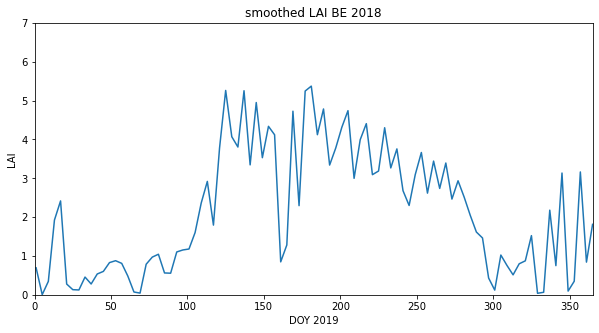

In [13]:
from pathlib import Path
import matplotlib.pyplot as plt

# read the datasets
ofile = Path('work/mydata.csv')
df1=pd.read_csv(ofile)
x = df1['doy']
lai = df1['Lai_500m']

classy='Deciduous Broadleaf Forests'
# plot 
x_size,y_size=(10,5)
fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))

axs.plot(x,lai,label=f"{classy} mean")
axs.set_title(f'smoothed LAI BE 2018')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_ylabel('LAI')
axs.set_xlabel('DOY 2019')
axs.set_xlim(0,365)